In [1]:
%matplotlib inline
import pymc3 as pm
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np
import theano.tensor as tt

In [2]:
latest_11 = np.array([437,235,478,525,505,704,508,485,591,896,768])
date_arr = np.array([1,2,3,4,5,6,7,8,9,10,11])

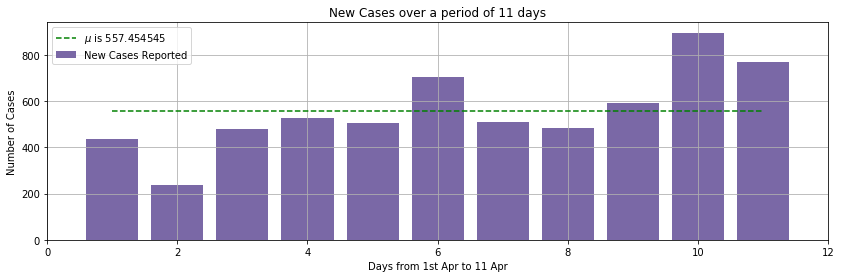

In [19]:
size = len(latest_11)

x = np.arange(size)

figsize(14,4)
plt.bar(date_arr,latest_11,label="New Cases Reported", color="#7A68A6")

lambda0 = np.mean(latest_11)

plt.title("New Cases over a period of 11 days")
plt.plot((1,size),(lambda0,lambda0),"g--",label="$\mu$ is %f" %lambda0)
plt.xlabel("Days from 1st Apr to 11 Apr")
plt.ylabel("Number of Cases")
plt.xlim(0,size+1)
plt.legend()
plt.grid()

In [4]:
with pm.Model() as pois_model:
    alpha = 1.0/latest_11.mean()  
    lambda_single = pm.Exponential("lambda_single", alpha)
    obs = pm.Poisson("obs",lambda_single,observed = latest_11)

In [5]:
with pois_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda_single]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:03<00:00, 11664.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


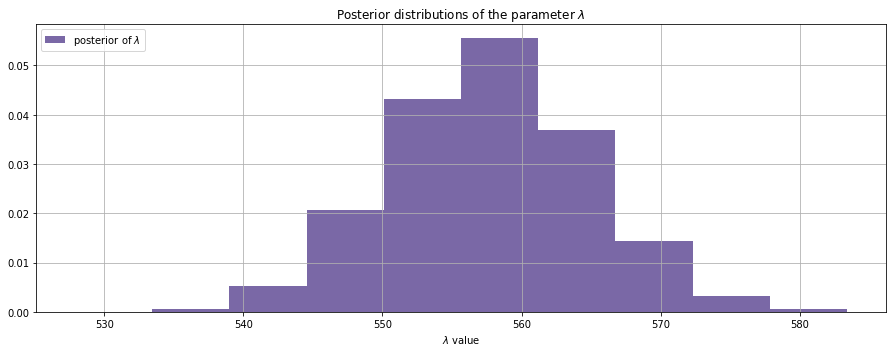

In [15]:
lambda_single_samples = trace['lambda_single']
figsize(12.5, 5)

plt.hist(lambda_single_samples, bins=10,
         label="posterior of $\lambda$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameter $\lambda$""")
plt.xlabel("$\lambda$ value")
plt.grid()
plt.tight_layout()

-


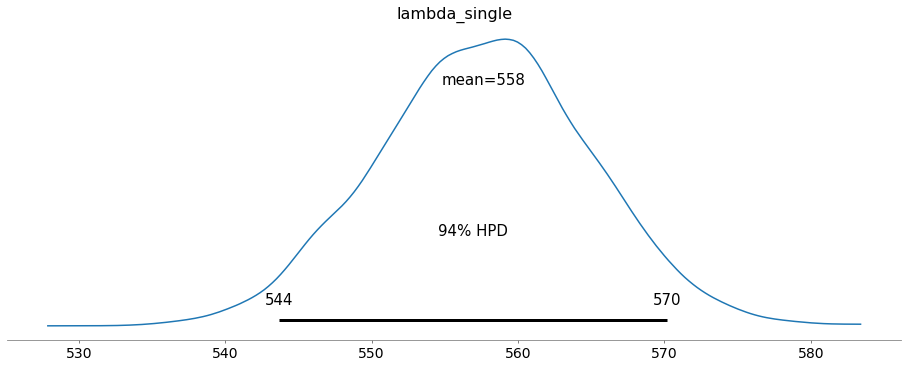

In [7]:
pm.plot_posterior(trace)
print("-")

In [8]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_single,557.646,7.152,543.703,570.183,0.151,0.107,2238.0,2238.0,2240.0,2139.0,1.0


In [9]:
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(x_new-x)))
    
def pois_mcmc(data,prior,iterations):
    
    data_size = len(data)
  
    accepted = []
    rejected = []
    
    if(data_size == 0):
        return accepted,rejected
  
    current = np.random.normal(prior,5)
    
    for i in range(iterations):
        proposed = np.random.normal(current,5)
        
        current_log_like = np.sum(np.log(stats.poisson(current).pmf(data)))
        new_log_like = np.sum(np.log(stats.poisson(proposed).pmf(data)))
        
        if(acceptance(current_log_like,new_log_like)):
            accepted.append(proposed)
            current = proposed
        else:
            rejected.append(proposed)
                
    return accepted,rejected

In [10]:
prior = np.max(latest_11)
acc,rej = pois_mcmc(latest_11,prior,10000)

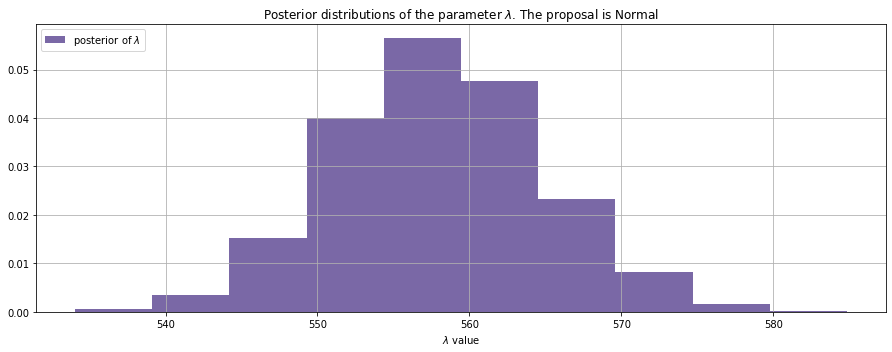

In [18]:
figsize(12.5, 5)

acc_filtered = acc[500:]
plt.hist(acc_filtered, histtype='stepfilled', bins=10,
         label="posterior of $\lambda$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameter $\lambda$. The proposal is Normal""")
plt.xlabel("$\lambda$ value")
plt.grid()
plt.tight_layout()

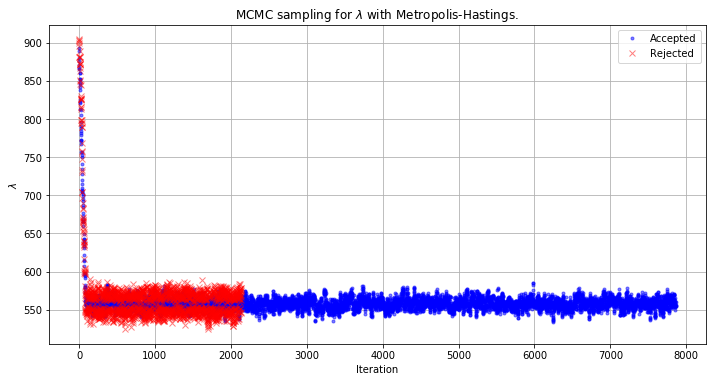

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( np.array(acc), 'b.', label='Accepted',alpha=0.5)
ax.plot( np.array(rej), 'rx', label='Rejected',alpha=0.5)

ax.set_xlabel("Iteration")
ax.set_ylabel("$\lambda$")
ax.set_title("MCMC sampling for $\lambda$ with Metropolis-Hastings.")
ax.grid()
ax.legend()


fig.tight_layout()

In [25]:
print("Inferred Mean and Observation Mean: ", np.mean(acc).round(0),np.mean(latest_11).round(0))
print("Total observed cases for the past 11 days: ",latest_11.sum())

Inferred Mean and Observation Mean:  560.0 557.0
Total observed cases for the past 11 days:  6132
